# Denoising scRNA-seq using DCA

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from dca.api import dca

/usr/local/lib/python3.6/dist-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


### Denoise Single Cell Dataset

In [3]:
import pandas as pd

mydata = pd.read_csv('../scPerturb_mcf7_data_reduced.csv')
print(mydata.shape)
mydata.head()

(61815, 2542)


,cell,pertname,timepoint,dose,target,canonical_smiles,MAL2,RPS6KB2,SLC2A3,RICTOR,...,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2,dataset
0,MCF7,TAK-901,24.0,10.0,Aurora Kinase,CCS(=O)(=O)c1cccc(-c2cc(C(=O)NC3CCN(C)CC3)c(C)...,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb
1,MCF7,BMS-536924,24.0,10.0,IGF-1R,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,scPerturb
2,MCF7,Enzastaurin (LY317615),24.0,10.0,PKC,Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)...,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb
3,MCF7,Carmofur,24.0,10.0,DNA/RNA Synthesis,CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,scPerturb
4,MCF7,AG-14361,24.0,10.0,PARP,CN(C)Cc1ccc(-c2nc3cccc4c3n2CCNC4=O)cc1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb


In [4]:
genexp = mydata.iloc[:,6:-1]
print(genexp.shape)
genexp.head()

(61815, 2535)


,MAL2,RPS6KB2,SLC2A3,RICTOR,RPS27L,KDM6B,RRAS,ZNF121,R3HDM4,TMED7,...,FSCN1,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2
0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
genexp.isna().sum().sum()

0

Estimate which noise model to use NB or ZINB

In [6]:
import numpy as np
from scipy.stats import nbinom, chi2
from scipy.optimize import minimize_scalar
from tqdm import tqdm

def fit_nb_model(data):
    # Fit Negative Binomial model
    mean = np.mean(data)
    dispersion = minimize_scalar(lambda phi: -nbinom.logpmf(data, 1/phi, mean).sum(), method='bounded', bounds=(0, 1)).x
    return mean, dispersion

def fit_zinb_model(data):
    # Fit Zero-Inflated Negative Binomial model
    zero_count = np.sum(data == 0)
    mean = np.mean(data)
    phi = minimize_scalar(lambda phi: -np.log(nbinom.pmf(0, 1/phi, mean)), method='bounded', bounds=(1e-10, 1)).x
    zero_inflation = zero_count / len(data)
    # return mean, phi, zero_count
    return mean, phi, zero_inflation

def likelihood_ratio_test(data):
    # Fit NB model
    nb_mean, nb_dispersion = fit_nb_model(data)
    
    # Fit ZINB model
    zinb_mean, zinb_phi, zero_inflation = fit_zinb_model(data)
    
    # Calculate likelihoods under NB and ZINB models
    nb_likelihood = nbinom.logpmf(data, 1/nb_dispersion, nb_mean).sum()
    epsilon = 1e-10  # small constant to avoid taking log of zero
    zinb_likelihood = np.log((1 - zero_inflation) * nbinom.pmf(data, 1/zinb_phi, zinb_mean) + zero_inflation * (data == 0) + epsilon).sum()
    
    # Compute likelihood ratio statistic
    lr_statistic = 2 * (zinb_likelihood - nb_likelihood)
    
    # Perform chi-square test for significance
    p_value = 1 - chi2.cdf(lr_statistic, df=1)
    
    return lr_statistic, p_value


# gene_expression_data = np.random.randint(0, 100, size=(num_samples, num_genes))
gene_expression_data = genexp.values
num_genes = gene_expression_data.shape[1]
# Perform likelihood ratio test for each gene
results = []
for i in tqdm(range(num_genes)):
    lr_statistic, p_value = likelihood_ratio_test(gene_expression_data[:, i])
    results.append((lr_statistic, p_value))

# Print results (replace with your preferred output format)
# for i, (lr_statistic, p_value) in enumerate(results):
#     print(f"Gene {i+1}: LR Statistic = {lr_statistic}, p-value = {p_value}")


  2%|▏         | 59/2535 [00:16<11:38,  3.55it/s]/usr/local/lib/python3.6/dist-packages/scipy/stats/_discrete_distns.py:272: RuntimeWarning: divide by zero encountered in log
  return coeff + n*log(p) + special.xlog1py(x, -p)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1945: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1946: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
100%|██████████| 2535/2535 [12:21<00:00,  3.42it/s]


In [7]:
# Define significance threshold
threshold = 0.05

# Counters for the number of genes favoring each model
nb_count = 0
zinb_count = 0

# Iterate through the LRT results for each gene
for lr_statistic, p_value in results:
    # Check if p-value is below the significance threshold
    if p_value < threshold:
        # If significant, increment the count for the ZINB model
        zinb_count += 1
    else:
        # If not significant, increment the count for the NB model
        nb_count += 1

# Decide which noise model to choose based on the proportion of genes favoring each model
total_genes = len(results)
proportion_zinb = zinb_count / total_genes
proportion_nb = nb_count / total_genes

# Print the results
print(f"Number of genes favoring NB model: {nb_count}")
print(f"Number of genes favoring ZINB model: {zinb_count}")
print(f"Proportion of genes favoring NB model: {proportion_nb:.2f}")
print(f"Proportion of genes favoring ZINB model: {proportion_zinb:.2f}")

# Choose the noise model based on the majority vote
if proportion_zinb > 0.5:
    print("Select ZINB noise model for denoising")
else:
    print("Select NB noise model for denoising")


Number of genes favoring NB model: 169
Number of genes favoring ZINB model: 2366
Proportion of genes favoring NB model: 0.07
Proportion of genes favoring ZINB model: 0.93
Select ZINB noise model for denoising


Denoise using ZINB noise model

In [8]:
%%time

original_gene_labels_set = set(genexp.columns.tolist())

# Create an Anndata object
adata_ae = sc.AnnData(genexp.values, obs=pd.DataFrame(index=genexp.index), var=pd.DataFrame(index=genexp.columns))
adata_ae.obs_names = genexp.index
adata_ae.var_names = genexp.columns

# preprocess before denoising
sc.pp.filter_genes(adata_ae, min_counts=1)

# run DCA
dca(adata_ae, ae_type= 'zinb')
denoised_adata_ae = adata_ae.X    # denoised!

# Get the set of denoised gene labels
denoised_gene_labels_set = set(adata_ae.var_names)

# Find the genes that were lost in the denoising process
lost_genes = original_gene_labels_set - denoised_gene_labels_set

# The denoised data is stored in `denoised_adata.X`
res_zinb = pd.DataFrame(denoised_adata_ae, index=adata_ae.obs_names, columns=adata_ae.var_names)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:898: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


dca: Successfully preprocessed 2519 genes and 61815 cells.



2024-03-21 16:05:51,952 [WARNING] From /rohlan/workspace/dca/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: user 42min 46s, sys: 6min 52s, total: 49min 39s
Wall time: 7min 48s


In [9]:
# this is raw denoised data (not normalized yet)
res_zinb

,MAL2,RPS6KB2,SLC2A3,RICTOR,RPS27L,KDM6B,RRAS,ZNF121,R3HDM4,TMED7,...,FSCN1,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2
0,0.865396,0.062352,0.062836,0.999930,0.101074,0.000089,0.046137,0.218030,0.096316,0.941786,...,1.206968,0.015475,0.108311,0.054415,0.002579,0.888657,0.011601,0.042638,0.336885,0.264465
1,1.019226,0.116288,0.053616,0.934856,0.195386,0.000116,0.061994,0.346428,0.128793,0.721197,...,2.863392,0.018017,0.157526,0.042647,0.002999,0.762314,0.010296,0.061337,0.415518,0.510392
2,0.298644,0.012925,0.011437,0.276682,0.014559,0.000064,0.023855,0.057734,0.018764,0.224045,...,0.338617,0.002127,0.046502,0.035447,0.000860,0.248390,0.001946,0.010024,0.079983,0.039469
3,1.498619,0.165847,0.118983,1.358647,0.262045,0.000156,0.132259,0.501519,0.208934,1.179386,...,3.798411,0.022658,0.262932,0.149688,0.005832,1.124372,0.017974,0.115031,0.615190,0.628489
4,0.543695,0.032809,0.081184,0.505791,0.041596,0.000108,0.043166,0.187998,0.075240,0.615489,...,0.677452,0.027745,0.066219,0.117661,0.003471,0.513883,0.023269,0.032266,0.216414,0.128793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61810,0.287021,0.018185,0.014585,0.269116,0.015073,0.000061,0.018962,0.069146,0.021495,0.234962,...,0.715331,0.003025,0.030922,0.060668,0.001311,0.210807,0.004275,0.008636,0.102332,0.078342
61811,0.269609,0.033651,0.010361,0.189248,0.060189,0.000057,0.016408,0.085736,0.030855,0.159573,...,0.849448,0.005545,0.033817,0.007740,0.001145,0.158770,0.002302,0.017898,0.093117,0.141236
61812,0.314988,0.019457,0.010793,0.243326,0.049971,0.000036,0.013889,0.065692,0.022150,0.277759,...,0.912016,0.001662,0.020643,0.002686,0.000638,0.203602,0.001112,0.011616,0.061257,0.109788
61813,0.264723,0.006062,0.005654,0.210951,0.008067,0.000038,0.010931,0.033649,0.009647,0.212872,...,0.399404,0.000687,0.023531,0.021017,0.000404,0.187806,0.000744,0.005127,0.060748,0.042690


In [10]:
# save the dataset
res_zinb.index = res_zinb.index.astype(int)
pd.concat([mydata.iloc[:,0:6], res_zinb, mydata.iloc[:,-1]], axis=1).to_csv('scPerturb_mcf7_denoised_zinb.csv', index=False)

In [12]:
pd.read_csv('./scPerturb_mcf7_denoised_zinb.csv')

,cell,pertname,timepoint,dose,target,canonical_smiles,MAL2,RPS6KB2,SLC2A3,RICTOR,...,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2,dataset
0,MCF7,TAK-901,24.0,10.0,Aurora Kinase,CCS(=O)(=O)c1cccc(-c2cc(C(=O)NC3CCN(C)CC3)c(C)...,0.865397,0.062352,0.062836,0.999930,...,0.015475,0.108311,0.054415,0.002579,0.888657,0.011601,0.042638,0.336885,0.264465,scPerturb
1,MCF7,BMS-536924,24.0,10.0,IGF-1R,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...,1.019226,0.116288,0.053616,0.934856,...,0.018017,0.157526,0.042647,0.002999,0.762314,0.010296,0.061337,0.415518,0.510392,scPerturb
2,MCF7,Enzastaurin (LY317615),24.0,10.0,PKC,Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)...,0.298644,0.012925,0.011437,0.276682,...,0.002127,0.046502,0.035447,0.000860,0.248390,0.001946,0.010024,0.079983,0.039469,scPerturb
3,MCF7,Carmofur,24.0,10.0,DNA/RNA Synthesis,CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O,1.498619,0.165847,0.118983,1.358647,...,0.022658,0.262932,0.149688,0.005832,1.124372,0.017974,0.115031,0.615190,0.628489,scPerturb
4,MCF7,AG-14361,24.0,10.0,PARP,CN(C)Cc1ccc(-c2nc3cccc4c3n2CCNC4=O)cc1,0.543695,0.032809,0.081184,0.505791,...,0.027745,0.066219,0.117661,0.003471,0.513883,0.023269,0.032266,0.216414,0.128793,scPerturb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61810,MCF7,Tacedinaline (CI994),24.0,10.0,HDAC,CC(=O)Nc1ccc(C(=O)Nc2ccccc2N)cc1,0.287021,0.018185,0.014585,0.269116,...,0.003025,0.030922,0.060668,0.001311,0.210807,0.004275,0.008636,0.102332,0.078342,scPerturb
61811,MCF7,Maraviroc,24.0,10.0,CCR,Cc1nnc(C(C)C)n1[C@@H]1C[C@H]2CC[C@@H](C1)N2CC[...,0.269609,0.033651,0.010361,0.189248,...,0.005545,0.033817,0.007740,0.001145,0.158770,0.002302,0.017898,0.093117,0.141236,scPerturb
61812,MCF7,PD173074,24.0,10.0,"FGFR,VEGFR",CCN(CC)CCCCNc1ncc2cc(-c3cc(OC)cc(OC)c3)c(NC(=O...,0.314988,0.019457,0.010793,0.243326,...,0.001662,0.020643,0.002686,0.000638,0.203602,0.001112,0.011616,0.061257,0.109788,scPerturb
61813,MCF7,Valproic acid sodium salt (Sodium valproate),24.0,10.0,"GABA Receptor,HDAC,Autophagy",CCCC(CCC)C(=O)[O-].[Na+],0.264723,0.006062,0.005654,0.210951,...,0.000687,0.023531,0.021017,0.000404,0.187806,0.000744,0.005127,0.060748,0.042690,scPerturb


In [13]:
# normalize per cell
sc.pp.normalize_per_cell(adata_ae)

In [14]:
res_zinb_norm = pd.DataFrame(adata_ae.X, index=adata_ae.obs_names, columns=adata_ae.var_names)
res_zinb_norm

,MAL2,RPS6KB2,SLC2A3,RICTOR,RPS27L,KDM6B,RRAS,ZNF121,R3HDM4,TMED7,...,FSCN1,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2
0,0.633879,0.045671,0.046026,0.732422,0.074034,0.000065,0.033794,0.159701,0.070549,0.689833,...,0.884072,0.011335,0.079335,0.039857,0.001889,0.650917,0.008497,0.031231,0.246759,0.193713
1,0.636834,0.072659,0.033500,0.584118,0.122081,0.000073,0.038735,0.216456,0.080473,0.450619,...,1.789109,0.011257,0.098426,0.026647,0.001874,0.476310,0.006433,0.038325,0.259625,0.318904
2,0.873910,0.037822,0.033467,0.809644,0.042603,0.000186,0.069805,0.168944,0.054908,0.655614,...,0.990883,0.006224,0.136077,0.103726,0.002516,0.726853,0.005696,0.029333,0.234050,0.115497
3,0.609885,0.067494,0.048422,0.552922,0.106643,0.000063,0.053825,0.204100,0.085029,0.479968,...,1.545820,0.009221,0.107004,0.060918,0.002374,0.457580,0.007315,0.046814,0.250361,0.255773
4,0.679511,0.041005,0.101464,0.632138,0.051986,0.000135,0.053949,0.234961,0.094035,0.769240,...,0.846681,0.034676,0.082760,0.147053,0.004338,0.642252,0.029082,0.040326,0.270474,0.160965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61810,0.683757,0.043321,0.034745,0.641104,0.035908,0.000146,0.045172,0.164725,0.051208,0.559739,...,1.704103,0.007206,0.073664,0.144527,0.003124,0.502196,0.010184,0.020573,0.243781,0.186630
61811,0.719730,0.089833,0.027659,0.505203,0.160675,0.000152,0.043801,0.228875,0.082367,0.425986,...,2.267628,0.014802,0.090276,0.020662,0.003057,0.423841,0.006145,0.047779,0.248580,0.377034
61812,0.745820,0.046071,0.025555,0.576142,0.118319,0.000086,0.032887,0.155545,0.052447,0.657672,...,2.159449,0.003935,0.048878,0.006359,0.001510,0.482084,0.002633,0.027505,0.145042,0.259953
61813,0.957734,0.021930,0.020454,0.763192,0.029185,0.000136,0.039546,0.121738,0.034902,0.770143,...,1.444992,0.002486,0.085132,0.076036,0.001461,0.679458,0.002693,0.018550,0.219780,0.154447


In [20]:
res_zinb_norm.index = res_zinb_norm.index.astype(int)
pd.concat([mydata.iloc[:,0:6], res_zinb_norm, mydata.iloc[:,-1]], axis=1).to_pickle('scPerturb_mcf7_denoised_zinb_normalized.pkl')

In [15]:
# log transform
sc.pp.log1p(adata_ae)

In [16]:
res_zinb_lop1p = pd.DataFrame(adata_ae.X, index=adata_ae.obs_names, columns=adata_ae.var_names)
res_zinb_lop1p

,MAL2,RPS6KB2,SLC2A3,RICTOR,RPS27L,KDM6B,RRAS,ZNF121,R3HDM4,TMED7,...,FSCN1,CXCL8,PRR15L,ATAD2,PDGFRA,BAX,LRPPRC,SH3GL1,ZWINT,RPS2
0,0.490957,0.044659,0.044998,0.549520,0.071422,0.000065,0.033235,0.148162,0.068172,0.524630,...,0.633435,0.011271,0.076345,0.039084,0.001887,0.501331,0.008461,0.030753,0.220547,0.177069
1,0.492764,0.070141,0.032951,0.460028,0.115185,0.000073,0.038004,0.195942,0.077399,0.371991,...,1.025722,0.011194,0.093878,0.026298,0.001872,0.389546,0.006412,0.037609,0.230814,0.276801
2,0.628027,0.037125,0.032919,0.593130,0.041720,0.000186,0.067477,0.156101,0.053453,0.504172,...,0.688578,0.006205,0.127581,0.098692,0.002513,0.546301,0.005679,0.028911,0.210302,0.109300
3,0.476163,0.065314,0.047286,0.440138,0.101331,0.000063,0.052426,0.185733,0.081607,0.392021,...,0.934453,0.009179,0.101657,0.059134,0.002371,0.376777,0.007288,0.045751,0.223432,0.227751
4,0.518503,0.040187,0.096640,0.489891,0.050680,0.000135,0.052544,0.211039,0.089872,0.570550,...,0.613390,0.034088,0.079513,0.137196,0.004328,0.496068,0.028667,0.039535,0.239390,0.149252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61810,0.521028,0.042409,0.034155,0.495369,0.035279,0.000146,0.044181,0.152485,0.049940,0.444519,...,0.994770,0.007180,0.071078,0.134991,0.003119,0.406928,0.010132,0.020365,0.218156,0.171118
61811,0.542167,0.086024,0.027283,0.408927,0.149002,0.000152,0.042869,0.206099,0.079151,0.354863,...,1.184064,0.014693,0.086431,0.020451,0.003052,0.353358,0.006126,0.046673,0.222007,0.319932
61812,0.557225,0.045041,0.025234,0.454980,0.111827,0.000086,0.032358,0.144572,0.051118,0.505414,...,1.150398,0.003928,0.047721,0.006339,0.001508,0.393449,0.002629,0.027133,0.135441,0.231074
61813,0.671788,0.021693,0.020247,0.567126,0.028767,0.000136,0.038784,0.114880,0.034307,0.571060,...,0.894042,0.002483,0.081702,0.073284,0.001460,0.518471,0.002689,0.018380,0.198671,0.143621


In [21]:
res_zinb_lop1p.index = res_zinb_lop1p.index.astype(int)
pd.concat([mydata.iloc[:,0:6], res_zinb_lop1p, mydata.iloc[:,-1]], axis=1).to_pickle('scPerturb_mcf7_denoised_zinb_norm_and_log1p.pkl')

Denoising using NB model

In [15]:
original_gene_labels_set = set(genexp.columns.tolist())

# Create an Anndata object
adata_ae = sc.AnnData(genexp.values, obs=pd.DataFrame(index=genexp.index), var=pd.DataFrame(index=genexp.columns))
adata_ae.obs_names = genexp.index
adata_ae.var_names = genexp.columns

# preprocess before denoising
sc.pp.filter_genes(adata_ae, min_counts=1)

# run DCA
dca(adata_ae)
denoised_adata_ae = adata_ae.X    # denoised!

# Get the set of denoised gene labels
denoised_gene_labels_set = set(adata_ae.var_names)

# Find the genes that were lost in the denoising process
lost_genes = original_gene_labels_set - denoised_gene_labels_set

# The denoised data is stored in `denoised_adata.X`
res_NB = pd.DataFrame(denoised_adata_ae, index=adata_ae.obs_names, columns=adata_ae.var_names)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:898: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


dca: Successfully preprocessed 2514 genes and 49452 cells.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [16]:
res_NB

,IFITM1,SHKBP1,AREG,CLASRP,JMJD8,PABPC1L,LIN7C,SESN3,SAMD1,FYN,...,FAM72B,PABPC1,SBNO2,MUC1,AASS,BOK,NUSAP1,CACNA2D1,CDH2,DHCR24
0,0.000571,0.278864,0.411114,0.038545,0.016526,0.587676,0.013803,0.321967,1.582601,0.262468,...,0.000802,0.719704,0.328326,0.110301,0.031919,0.018706,0.116565,0.130935,0.207832,0.315743
1,0.001008,0.066671,0.149094,0.018331,0.007928,0.171366,0.018417,0.070594,0.494154,0.084692,...,0.001925,0.250534,0.070669,0.044924,0.011536,0.011062,0.034975,0.035479,0.121022,0.080718
2,0.000610,0.528679,0.771453,0.071323,0.046241,1.416316,0.036061,0.621702,3.401655,0.668029,...,0.001161,1.103462,0.755571,0.198962,0.089398,0.030803,0.179534,0.247459,0.391712,0.629994
3,0.000081,0.030110,0.070935,0.004243,0.000936,0.064069,0.006358,0.023524,0.182970,0.058977,...,0.000201,0.079107,0.042259,0.007486,0.004160,0.001695,0.008051,0.010684,0.027034,0.035764
4,0.000490,0.303046,0.396074,0.028721,0.008160,0.537598,0.006728,0.201858,1.687385,0.221397,...,0.000680,0.496003,0.236325,0.066263,0.024366,0.007118,0.088844,0.107752,0.144304,0.282264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49447,0.000543,0.291736,0.522548,0.051728,0.020552,0.766999,0.053389,0.216850,2.084685,0.430860,...,0.001293,0.840021,0.385166,0.098853,0.031755,0.015100,0.096566,0.117278,0.275899,0.389697
49448,0.000191,0.070635,0.074785,0.008917,0.002082,0.181081,0.002009,0.063268,0.792807,0.053434,...,0.000240,0.193575,0.084686,0.036579,0.003487,0.002144,0.025993,0.031528,0.092129,0.071612
49449,0.000248,0.122249,0.172915,0.014781,0.002354,0.417126,0.002280,0.167382,1.126778,0.155790,...,0.000232,0.291638,0.223855,0.043462,0.008540,0.003559,0.032877,0.063214,0.107354,0.145220
49450,0.000343,0.246226,0.369001,0.028811,0.009119,0.571204,0.016591,0.170726,1.517998,0.303897,...,0.000857,0.579190,0.250128,0.056294,0.015438,0.006962,0.053097,0.081473,0.160644,0.335117


In [23]:
res_NB.index = res_NB.index.astype(int)
pd.concat([mydata.iloc[:,0:6], res_NB, mydata.iloc[:,-1]], axis=1).to_csv('mcf7_sc_train_denoised_NB.csv', index=False)

In [17]:
# Normalize the data and save the normalized data separately for late analysis
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
res_NB_norm = pd.DataFrame(adata_ae.X, index=adata_ae.obs_names, columns=adata_ae.var_names)

In [ ]:
sc.pp.pca(adata_ae)

In [9]:
# without zinb normalization
res_df2

,IFITM1,SHKBP1,AREG,CLASRP,JMJD8,PABPC1L,LIN7C,SESN3,SAMD1,FYN,...,FAM72B,PABPC1,SBNO2,MUC1,AASS,BOK,NUSAP1,CACNA2D1,CDH2,DHCR24
0,0.000571,0.278864,0.411114,0.038545,0.016526,0.587676,0.013803,0.321967,1.582601,0.262468,...,0.000802,0.719704,0.328326,0.110301,0.031919,0.018706,0.116565,0.130935,0.207832,0.315743
1,0.001008,0.066671,0.149094,0.018331,0.007928,0.171366,0.018417,0.070594,0.494154,0.084692,...,0.001925,0.250534,0.070669,0.044924,0.011536,0.011062,0.034975,0.035479,0.121022,0.080718
2,0.000610,0.528679,0.771453,0.071323,0.046241,1.416316,0.036061,0.621702,3.401655,0.668029,...,0.001161,1.103462,0.755571,0.198962,0.089398,0.030803,0.179534,0.247459,0.391712,0.629994
3,0.000081,0.030110,0.070935,0.004243,0.000936,0.064069,0.006358,0.023524,0.182970,0.058977,...,0.000201,0.079107,0.042259,0.007486,0.004160,0.001695,0.008051,0.010684,0.027034,0.035764
4,0.000490,0.303046,0.396074,0.028721,0.008160,0.537598,0.006728,0.201858,1.687385,0.221397,...,0.000680,0.496003,0.236325,0.066263,0.024366,0.007118,0.088844,0.107752,0.144304,0.282264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49447,0.000543,0.291736,0.522548,0.051728,0.020552,0.766999,0.053389,0.216850,2.084685,0.430860,...,0.001293,0.840021,0.385166,0.098853,0.031755,0.015100,0.096566,0.117278,0.275899,0.389697
49448,0.000191,0.070635,0.074785,0.008917,0.002082,0.181081,0.002009,0.063268,0.792807,0.053434,...,0.000240,0.193575,0.084686,0.036579,0.003487,0.002144,0.025993,0.031528,0.092129,0.071612
49449,0.000248,0.122249,0.172915,0.014781,0.002354,0.417126,0.002280,0.167382,1.126778,0.155790,...,0.000232,0.291638,0.223855,0.043462,0.008540,0.003559,0.032877,0.063214,0.107354,0.145220
49450,0.000343,0.246226,0.369001,0.028811,0.009119,0.571204,0.016591,0.170726,1.517998,0.303897,...,0.000857,0.579190,0.250128,0.056294,0.015438,0.006962,0.053097,0.081473,0.160644,0.335117


In [25]:
res_df_index = res_df.index.astype(int)
pd.concat([mydata.iloc[:,0:6], res_df], axis =1)

AttributeError: 'Int64Index' object has no attribute 'index'

## scRNA-seq Simulation using Splatter R package and rpy2

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats



R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    r

## Generate AnnData objects and analyze in Scanpy

In [3]:
import tensorflow as tf
tf.__version__

'2.4.4'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from dca.api import dca

/usr/local/lib/python3.6/dist-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [5]:
import pandas as pd

In [8]:
data = pd.read_csv('../mcf7_sc_train.csv')
print(data.shape)
data.head()

(49452, 2542)


,cell,pertname,timepoint,dose,target,canonical_smiles,IFITM1,SHKBP1,AREG,CLASRP,...,PABPC1,SBNO2,MUC1,AASS,BOK,NUSAP1,CACNA2D1,CDH2,DHCR24,dataset
0,MCF7,Costunolide,24.0,10.0,Telomerase,C=C1C(=O)O[C@@H]2/C=C(\C)CC/C=C(\C)CC[C@@H]12,0.0,2.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb
1,MCF7,Tucidinostat (Chidamide),24.0,10.0,HDAC,Nc1cc(F)ccc1NC(=O)c1ccc(CNC(=O)/C=C/c2cccnc2)cc1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb
2,MCF7,CYC116,24.0,10.0,"Aurora Kinase,VEGFR",Cc1nc(N)sc1-c1ccnc(Nc2ccc(N3CCOCC3)cc2)n1,0.0,0.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,scPerturb
3,MCF7,Raltitrexed,24.0,10.0,DNA/RNA Synthesis,Cc1nc(=O)c2cc(CN(C)c3ccc(C(=O)N[C@@H](CCC(=O)O...,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scPerturb
4,MCF7,Gandotinib (LY2784544),24.0,10.0,JAK,Cc1cc(Nc2cc(CN3CCOCC3)c3nc(C)c(Cc4ccc(Cl)cc4F)...,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,scPerturb


In [19]:
adata = sc.AnnData(sub_data.values, obs=pd.DataFrame(index=sub_data.index), var=pd.DataFrame(index=sub_data.columns))
sc.pp.filter_genes(adata, min_counts=1)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [20]:
adata

AnnData object with n_obs × n_vars = 100 × 1717
    var: 'n_counts'

In [6]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:875: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "obs")
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:898: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [21]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [7]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [8]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [9]:
%%time

adata_ae = sc.AnnData(sub_data.values, obs=pd.DataFrame(index=sub_data.index), var=pd.DataFrame(index=sub_data.columns))
adata_ae.obs_names = sub_data.index
adata_ae.var_names = sub_data.columns

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

# Store the denoised data in a separate attribute
adata_ae.raw = adata_ae

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

NameError: name 'sub_data' is not defined

In [26]:
denoised_data = pd.DataFrame(adata_ae.raw.X, index=adata_ae.raw.obs_names, columns=adata_ae.raw.var_names)

In [27]:
denoised_data

,SHKBP1,AREG,CLASRP,JMJD8,PABPC1L,LIN7C,SESN3,SAMD1,FYN,LAPTM4B,...,TBC1D30,ANAPC11,GAS2L3,PABPC1,SBNO2,MUC1,NUSAP1,CACNA2D1,CDH2,DHCR24
0,1.578025,0.344357,0.005375,0.045597,0.412171,0.000338,0.083610,1.208167,0.017043,0.014341,...,2.198664,0.107121,0.022885,0.766429,0.475822,0.026307,0.008299,0.021634,0.034268,0.115901
1,0.062932,0.082035,0.003069,0.025596,0.030293,0.000364,0.037376,1.086371,0.019650,0.004087,...,0.266467,0.041275,0.015678,0.151839,0.026357,0.008647,0.007335,0.024163,0.067730,0.066859
2,0.166359,2.150326,0.639853,0.031029,0.348013,0.000364,0.024491,3.715061,0.084955,0.008470,...,1.648589,1.161243,0.187319,0.109678,0.493563,0.086866,0.106982,0.214872,0.053729,0.441485
3,0.021807,0.078221,0.003763,0.019849,0.065827,0.000407,0.080418,0.091335,0.017100,0.006668,...,0.311978,0.035477,0.016765,0.058805,0.228850,0.003241,0.022242,0.023045,0.023781,0.042038
4,0.195422,0.207930,0.087512,0.092220,0.109749,0.000553,0.026638,3.981832,0.050891,0.008419,...,0.462860,0.911641,0.032390,0.431616,0.129633,0.163331,0.014945,0.040881,0.173589,0.257497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.241003,1.660668,0.272381,0.478032,1.162804,0.005552,0.476037,4.236612,0.996096,0.063663,...,4.886960,1.827205,0.424404,1.040374,1.984713,0.121677,0.382857,0.452275,0.509884,0.625359
96,0.040241,0.244296,0.014607,0.053330,0.097742,0.001027,0.101619,0.704408,0.079939,0.014505,...,0.632885,0.267214,0.077406,0.108399,0.147814,0.013597,0.091313,0.050277,0.067664,0.111142
97,0.114511,0.212340,0.026648,0.045055,0.118399,0.000924,0.091211,0.771282,0.046390,0.010206,...,0.596668,0.150162,0.057730,0.157466,0.157866,0.018692,0.025459,0.043888,0.033239,0.109787
98,0.073345,0.149039,0.008310,0.034001,0.075290,0.000472,0.040047,0.329003,0.023634,0.008603,...,0.326738,0.091865,0.049034,0.075052,0.138619,0.008730,0.022514,0.023133,0.021531,0.092801


In [23]:
adata_ae

AnnData object with n_obs × n_vars = 100 × 1717
    obs: 'dca_split', 'n_counts', 'size_factors'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1218: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


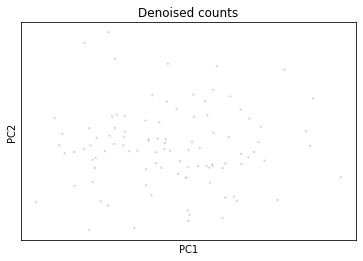

In [28]:
sc.pl.pca_scatter(adata_ae, size=20, title='Denoised counts')

In [10]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:875: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "obs")
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:898: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


dca: Successfully preprocessed 198 genes and 2000 cells.



2024-03-14 01:57:56,262 [WARNING] From /rohlan/workspace/dca/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


CPU times: user 54.7 s, sys: 16.1 s, total: 1min 10s
Wall time: 50 s


In [11]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## PCA: Simulation with and without dropout effect

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1218: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"
... storing 'Batch' as categorical


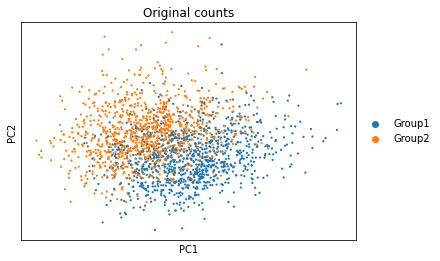

... storing 'Batch' as categorical


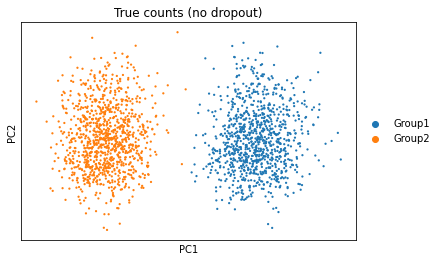

... storing 'Batch' as categorical


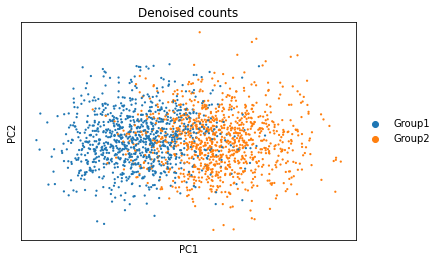

In [12]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

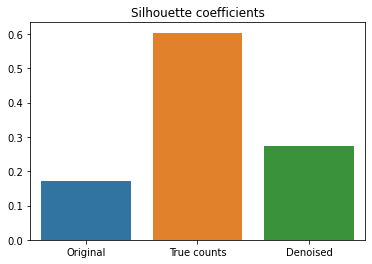

In [13]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_pca'][:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [14]:
adata._sanitize()
adata_ae._sanitize()

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1218: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  key for key in df.columns if infer_dtype(df[key]) == "string"


In [15]:
adata.obs.Group

Cell
Cell1       Group1
Cell2       Group1
Cell3       Group2
Cell4       Group1
Cell5       Group1
             ...  
Cell1996    Group2
Cell1997    Group2
Cell1998    Group2
Cell1999    Group2
Cell2000    Group1
Name: Group, Length: 2000, dtype: category
Categories (2, object): [Group1, Group2]

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


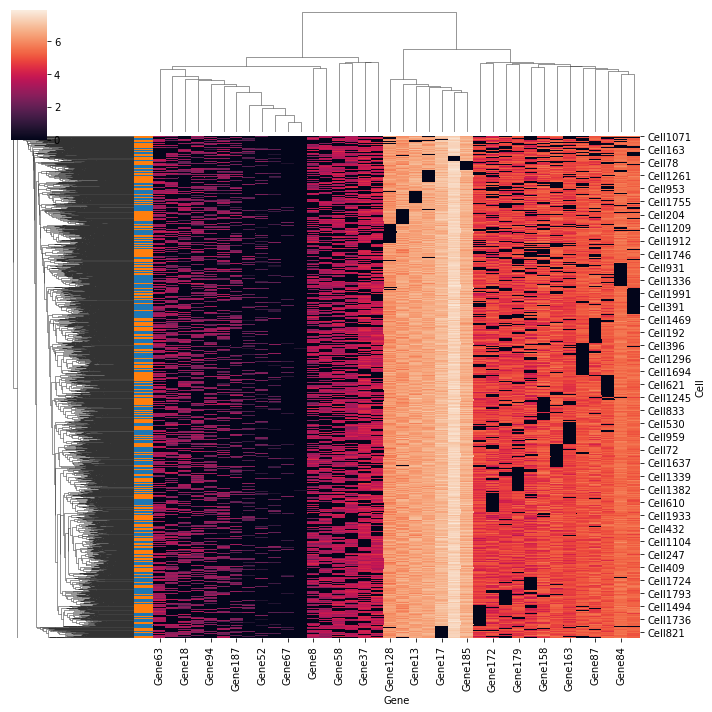

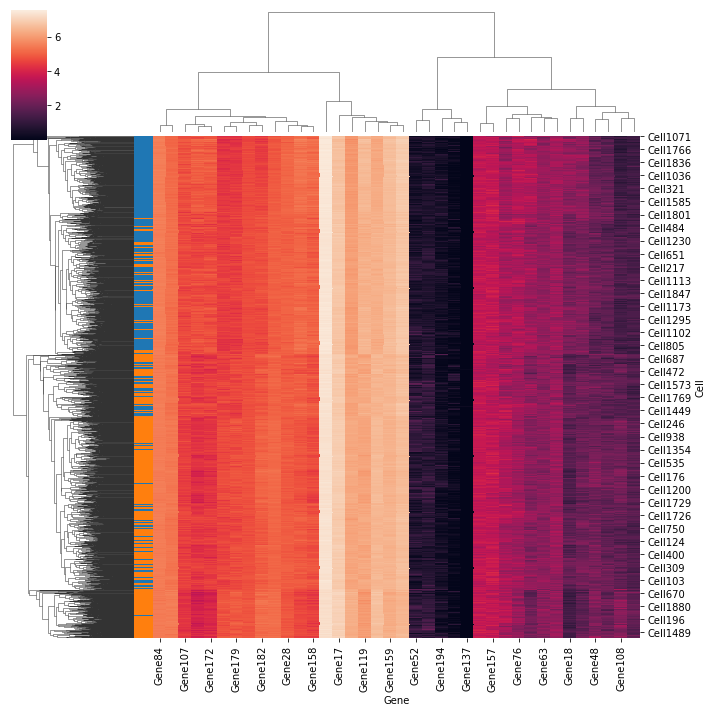

In [16]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [17]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

2024-03-14 01:59:37,379 [WARNING] R[write to console]: Getting parameters...



2024-03-14 01:59:37,411 [WARNING] R[write to console]: Creating simulation object...

2024-03-14 01:59:37,607 [WARNING] R[write to console]: Simulating library sizes...

2024-03-14 01:59:37,627 [WARNING] R[write to console]: Simulating gene means...

2024-03-14 01:59:37,731 [WARNING] R[write to console]: Simulating group DE...

2024-03-14 01:59:37,840 [WARNING] R[write to console]: Simulating cell means...

2024-03-14 01:59:37,930 [WARNING] R[write to console]: Simulating BCV...

2024-03-14 01:59:38,063 [WARNING] R[write to console]: Simulating counts...

2024-03-14 01:59:38,162 [WARNING] R[write to console]: Simulating dropout (if needed)...

2024-03-14 01:59:38,368 [WARNING] R[write to console]: Sparsifying assays...

2024-03-14 01:59:38,370 [WARNING] R[write to console]: Automatically converting to sparse matrices, threshold = 0.95

2024-03-14 01:59:38,381 [WARNING] R[write to console]: Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix

2024-03-14 01:59:38,384 [WAR

In [18]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:875: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "obs")
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:898: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  names = self._prep_dim_index(names, "var")


AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

In [16]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [19]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

dca: Successfully preprocessed 198 genes and 2000 cells.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


         Falling back to preprocessing with `sc.pp.pca` and default params.


CPU times: user 2h 3min 29s, sys: 10.7 s, total: 2h 3min 40s
Wall time: 3min 19s


AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_pca', 'X_tsne'

... storing 'Batch' as categorical
... storing 'Group' as categorical


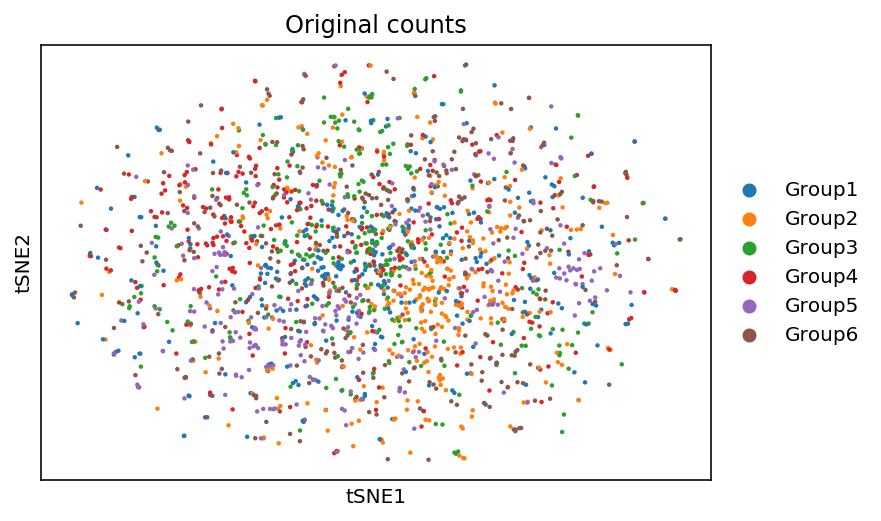

... storing 'Batch' as categorical
... storing 'Group' as categorical


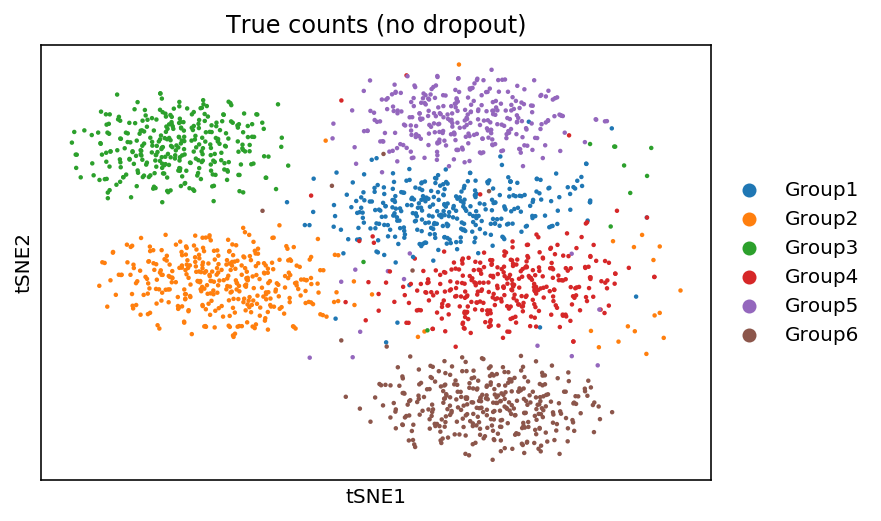

... storing 'Batch' as categorical
... storing 'Group' as categorical


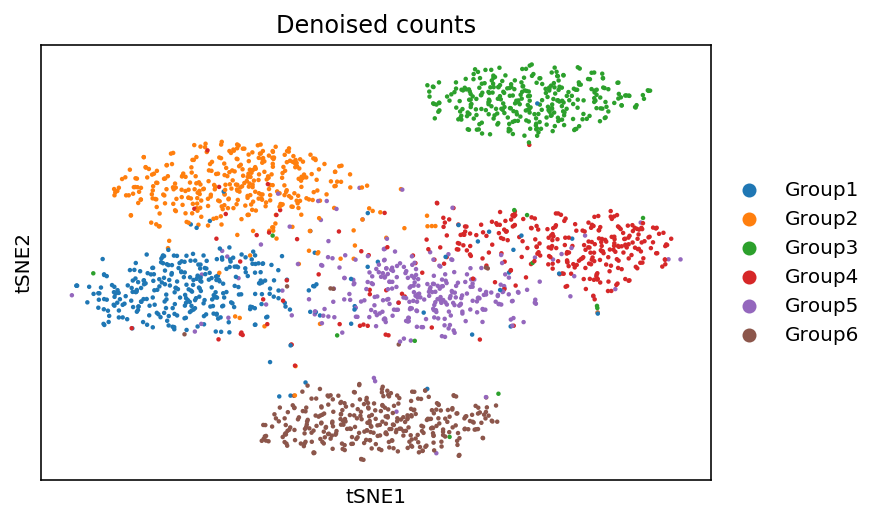

In [18]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

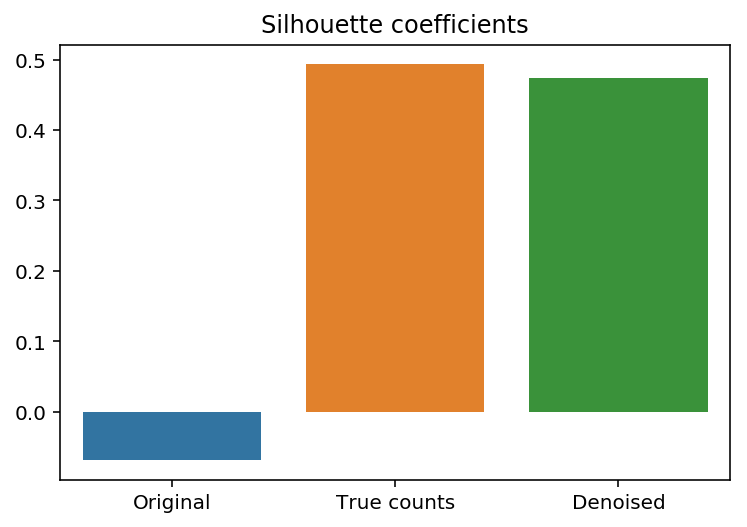

In [19]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_tsne'], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_tsne'], adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm['X_tsne'], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [20]:
adata

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'pca', 'Group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

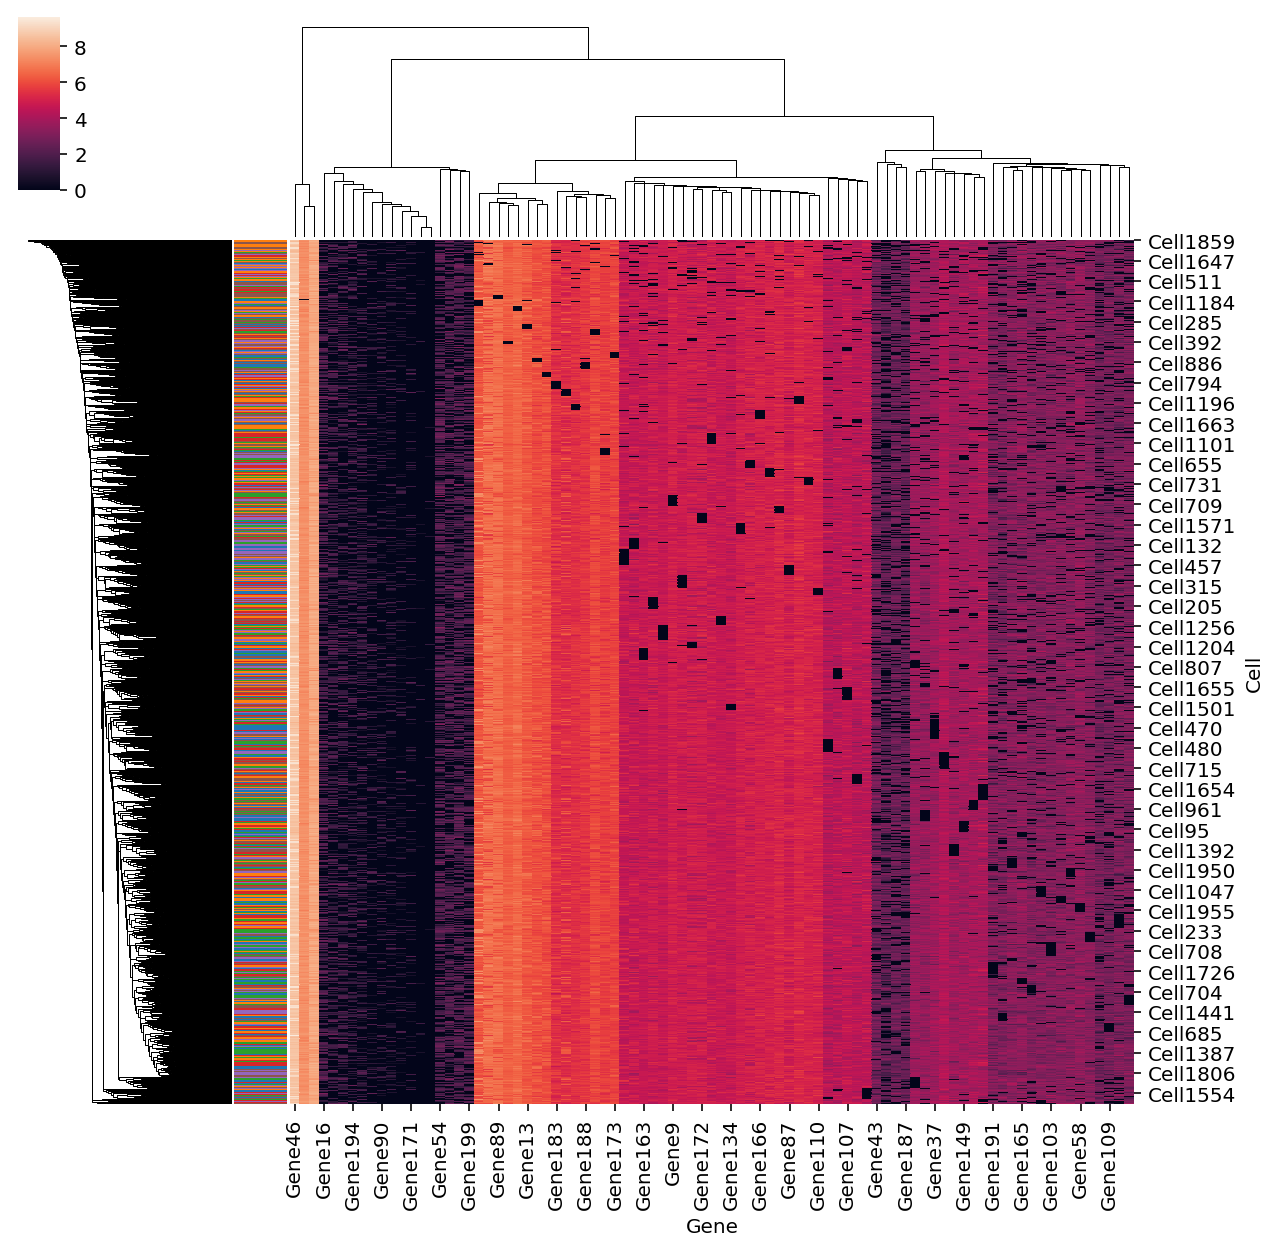

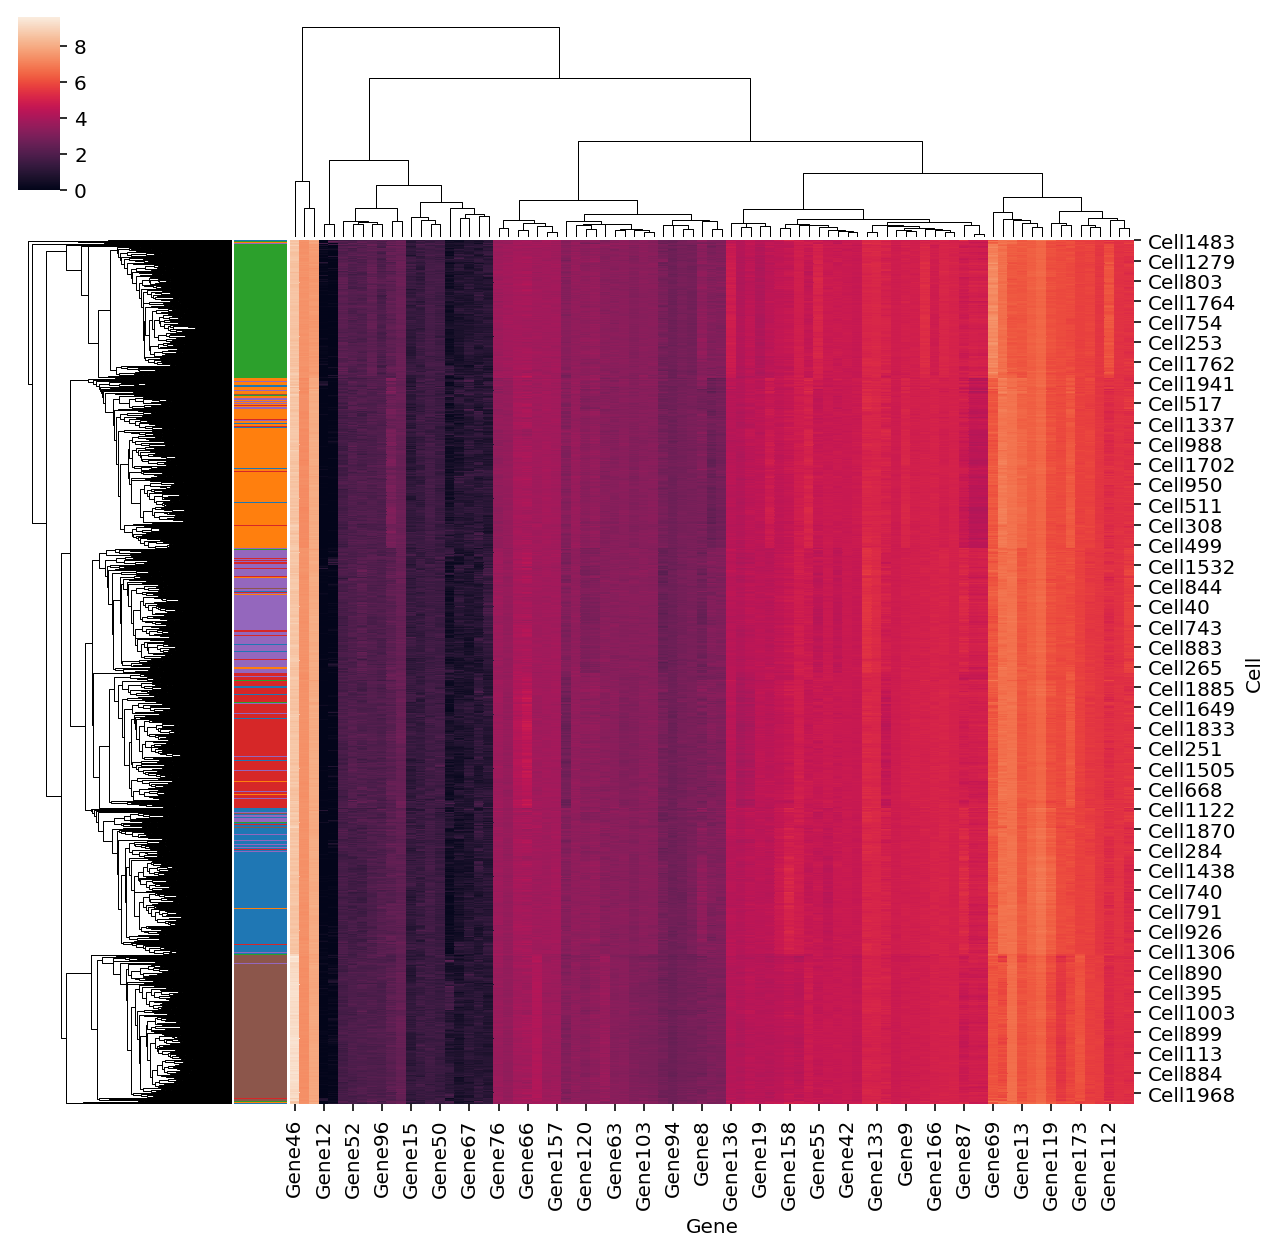

In [21]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

Testing Batch Effects in Denoised Data

In [1]:
import umap
import pandas as pd

In [3]:
sample_data = pd.read_csv('../l1000_scPerturb_sample_for_umap.csv', index_col = 0)
sample_data.head()

,dataset,cell,pertname,timepoint,dose,target,canonical_smiles,A2M,AASS,ABCA1,...,ZNF768,ZNF770,ZNF787,ZNF83,ZNF91,ZNF92,ZRANB2,ZSCAN18,ZWILCH,ZWINT
76045,scPerturb,MCF7,Daphnetin,24.0,10.0,"PKA,EGFR,PKC",O=c1ccc2ccc(O)c(O)c2o1,0.000300,0.003875,0.020925,...,0.000202,0.000118,0.042360,0.199554,0.000143,0.527400,0.150138,0.000735,0.300579,0.068727
69500,scPerturb,MCF7,CYC116,24.0,10.0,"Aurora Kinase,VEGFR",Cc1nc(N)sc1-c1ccnc(Nc2ccc(N3CCOCC3)cc2)n1,0.000986,0.008783,0.050306,...,0.000328,0.000202,0.086678,0.939376,0.000272,0.586367,0.342768,0.001075,0.529080,0.110106
47310,L1000,MCF7,methotrexate,24 h,10 uM,DHFR,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...,1.084739,2.789461,2.484693,...,6.915144,3.359082,6.216452,4.967231,3.059026,1.620710,4.682415,5.497812,2.705827,4.344835
42176,scPerturb,MCF7,CUDC-907,24.0,10.0,"HDAC,PI3K",COc1ccc(-c2nc(N3CCOCC3)c3sc(CN(C)c4ncc(C(=O)NO...,0.006814,0.014175,0.044565,...,0.001477,0.000554,0.060989,0.063591,0.001506,0.184019,0.083937,0.003478,0.208535,0.133063
64348,L1000,MCF7,iproniazid,24 h,10 uM,NaN,CC(C)NNC(=O)c1ccncc1,4.589243,2.636235,3.204675,...,5.412667,4.639755,3.974059,4.482642,3.156080,3.079102,5.197243,2.805800,4.564714,6.636011


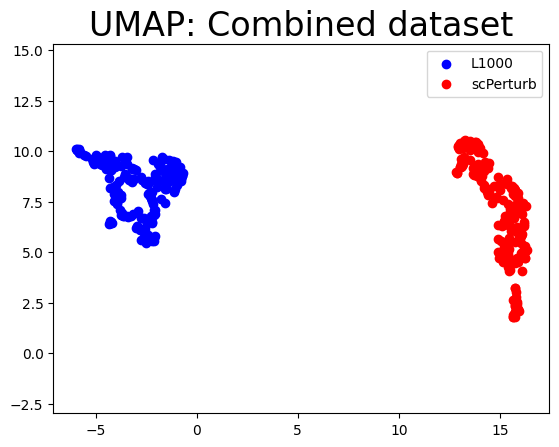

In [5]:
import umap
import matplotlib.pyplot as plt

# Subset your DataFrame to include only the gene expression columns
data = sample_data.iloc[:, 7:-1]

# Perform UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Create a color map
cmap = {'L1000': 'blue', 'scPerturb': 'red'}  # replace with your actual datasets and desired colors

# Create a list of colors for each point
colors = [cmap[x] for x in sample_data['dataset']]

# Create scatter plots for each dataset separately to add labels
for dataset in cmap.keys():
    plt.scatter(embedding[sample_data['dataset'] == dataset, 0], 
                embedding[sample_data['dataset'] == dataset, 1], 
                c=cmap[dataset], 
                label=dataset)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP: Combined dataset', fontsize=24)
plt.savefig('umap.png')
plt.legend()  # Display the legend
plt.show()